In [135]:
#IMPORTS
import os
import pandas as pd
import numpy as np  # a conventional alias
import sklearn.feature_extraction.text as text
import matplotlib.pyplot as plt
import bottleneck
import heapq
import xlsxwriter
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'ignore', 'under': 'ignore'}

In [175]:
#FUNCTIONS
#NMF Algorithm: 
#(A - n x m; U - n x k; V - k x m); k - topics, n - documents, m - words
def nmf(A, k, iter=100):
    (n, m) = A.shape
    
    #Initializing positive U and V
    zero_entries = True
    while zero_entries:
        U = np.random.rand( n, k )
        V = np.random.rand( k, m )
        zero_entries = (U.any()==0)&(V.any()==0)
    
    #Multiplicative updates(Lee and Seung), 
    #Making sure that denominators of multiplicative updates are not zero
    for i in range(iter):
        numU=np.dot( A, V.T )
        numV=np.dot( U.T, A )
        denU=np.dot( np.dot( U, V ), V.T )
        denV=np.dot( np.dot( U.T, U ), V )
        if (denU.all()!=0)&(denV.all()!=0):
            #U = U * np.divide(np.dot( A, V.T ), np.dot( np.dot( U, V ), V.T ))
            #V = V * np.divide(np.dot( U.T, A ), np.dot( np.dot( U.T, U ), V ))
            U = U * np.divide(numU, denU)
            V = V * np.divide(numV, denV)
            
    return U, V, n, m

# function makes in a matrix A with all the documents/words
#takes the from_doc - to_doc variables that indicate which rows are given more weight
#param - off-set parameter, k - number of topics
def ssnmf(A, B, from_doc, to_doc, param, k, level, iter=100):
    (n, m) = A.shape
    L = label_matrix(n, k, from_doc, to_doc, level)
    
    #Initializing positive U, V, W
    zero_entries = True
    while zero_entries:
        U = np.random.rand( n, k )
        W = np.random.rand( k, k )
        V = np.random.rand( k, m )
        zero_entries = (U.any()==0)&(V.any()==0)&(W.any()==0)
    
    #Multiplicative updates for Semi-Supervized Nonnegative Matrix Factorization 
    #Making sure that denominators of multiplicative updates are not zero
    for i in range(iter):
        numV=np.dot( U.T, A )
        denV=np.dot( np.dot( U.T, U ), V )
        #numV=np.dot( U.T, A )+param*np.dot( W.T, np.multiply(L,A) )
        #denV=np.dot( np.dot( U.T, U ), V )+param*np.dot( np.dot( W.T, W ), V )
        if (denV.all()!=0):
            V = V * np.divide(numV, denV)
        numW=np.dot( U.T, np.multiply(L,B) )
        denW=np.dot( U.T, np.multiply(L,np.dot( U, W )) )
        if(denW.all()!=0):
            W = W * np.divide(numW, denW)
        numU=np.dot( A, V.T ) +param*np.dot( np.multiply(L,B), W.T )
        denU=np.dot( np.dot( U, V ), V.T )+param*np.dot( U, np.dot( W.T, W ) )
        if (denU.all()!=0):
            U = U * np.divide(np.dot( A, V.T ), np.dot( np.dot( U, V ), V.T ))    
            
            
    return U, W, V, n, m

#creating matrix with partially known labels of words x topics
def known_words(num_topics, vocab, emotion_files):
    return #mxk matrix


# a weight matrix 
def make_one(a):
    if a != 0:
        a = 1
    return a
def weight_matrix(label_matrix):
    L= []
    for i in label_matrix:
        L.append(list(map(make_one, i)))
    return np.array(L)

#generate an array with topic+numbers for labeling graphs
def labels_generator(number, string):
    return [string + " " + x for x in np.char.mod('%d', np.arange(number+1))[1:]]

#vectorizer from sklearn
vectorizer = text.CountVectorizer(input='filename', stop_words='english',  min_df=5)

#function that returns indexes of top i values each row of a matrix
def top_i_indexes(matrix, i):
    (r, c) = matrix.shape
    return np.array([bottleneck.argpartsort(-matrix[n], i)[:i] for n in np.arange(r)])

#function takes matrix, number of rows and an an array size of a column and 
#gives out a matrix with the specified indexes in each column
def indexed_matrix(matrix, indexes):
    (r, c) = matrix.shape
    return np.array([matrix[n , indexes[n]] for n in range(r)])

#creating a matrix with specified number of rows with specified indexes from an array 
def names_matrix(array, indexes):
    (r,c) = indexes.shape
    return np.array([vocab[indexes[n]] for n in range(r)])


#function for re-writing files without errors
def error_free(file_names):
    for f in file_names:
        file = open( f, "r", errors = 'ignore' )
        string_data = file.read()
        file.close()
        fil = open( f, "w" )     
        fil.write(string_data)                        
        fil.close()
        

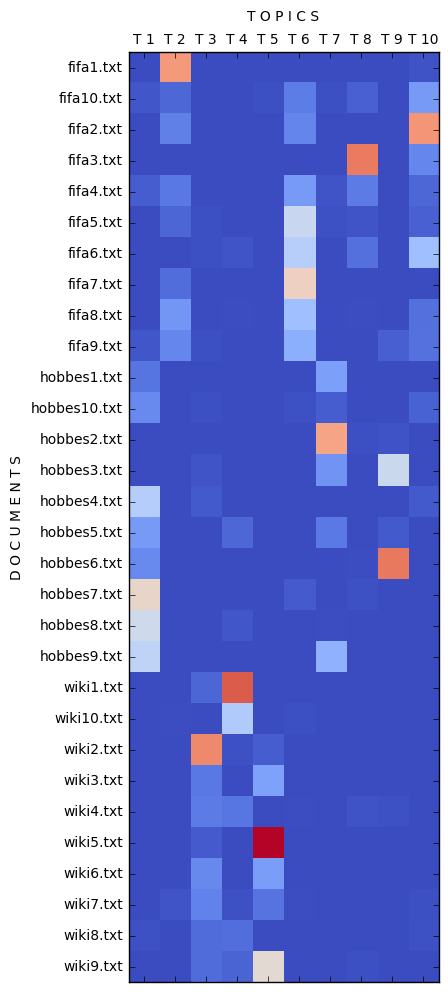

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
1,like,goal,north,000,000,corner,sense,inside,sense,shot
2,things,half,range,dog,coyote,post,imagination,ball,thought,game
3,man,fired,species,world,years,minutes,man,minutes,thoughts,goal
4,men,brazil,canis,years,red,left,thing,box,imagination,minutes
5,mind,net,wolf,ago,wolves,just,parts,penalty,parts,kick
6,time,hard,wolves,human,eastern,time,men,long,desire,free
7,past,box,human,like,wolf,area,time,lead,times,home
8,place,second,fear,early,north,far,past,later,man,past
9,thoughts,ball,12,hunting,species,effort,things,post,way,ball
10,say,victory,long,species,great,goals,great,time,time,wide


In [176]:
#TEST DOCUMENTS NMF
#setting parameters
CORPUS_PATH = '/Users/Mac/Google Drive/Thesis Anna/From PrHunter/TestCodeAndData/fifa_raw'
num_topic = 10
num_top_words = 10

#importing and vectorizing data
doc_names = os.listdir(CORPUS_PATH)
file_names = sorted([os.path.join(CORPUS_PATH, fn) for fn in os.listdir(CORPUS_PATH)])
dtm = np.array(vectorizer.fit_transform(file_names).toarray())
vocab = np.array(vectorizer.get_feature_names())


#analysis with NMF
U,V,n,m = nmf(dtm, num_topic)
topV=np.array( indexed_matrix( V, top_i_indexes( V, num_top_words ) ) )
topV_names=np.array( names_matrix( topV, top_i_indexes( V, num_top_words ) ) )



#plotting document-by-topic matrix as a heatmap
plt.matshow(U, cmap="coolwarm")
plt.yticks(range(n), os.listdir(CORPUS_PATH))
plt.xticks(range(num_topic), labels_generator(num_topic, "T"))
plt.xlabel("T O P I C S", labelpad = -700)
plt.ylabel("D O C U M E N T S")
plt.show()


#printing top words for each topic
pd.DataFrame(data=topV_names.T, columns=labels_generator(num_topic, "Topic"), index = range(1, num_top_words+1))

In [177]:
#Afghan - by page
#setting parameters
CORPUS_PATH = '/Users/Mac/Google Drive/Thesis Anna/From PrHunter/Afgan Data/txt_data_bypage'


#importing and vectorizing data
doc_names = os.listdir(CORPUS_PATH)
file_names = sorted([os.path.join(CORPUS_PATH, fn) for fn in os.listdir(CORPUS_PATH)])
dtm = np.array(vectorizer.fit_transform(file_names).toarray())
vocab = np.array(vectorizer.get_feature_names())

#deleting "afghan" and "afghanistan"
afg_ind = [(list(vocab)).index("afghanistan"), (list(vocab)).index("afghan"), (list(vocab)).index("mujahideen")]
dtm = np.delete(dtm, afg_ind, 1)
vocab = np.delete(vocab, afg_ind)

In [178]:
#analysis
num_topic = 10
num_top_words = 10
U,V,n,m = nmf(dtm, num_topic)
topV=np.array( indexed_matrix( V, top_i_indexes( V, num_top_words ) ) )
topV_names=np.array( names_matrix( topV, top_i_indexes( V, num_top_words ) ) )

#top words in all topics
#printing top words for each topic
pd.DataFrame(data=topV_names.T, columns=labels_generator(num_topic, "Topic"), index = range(1, num_top_words+1))

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
1,war,people,people,regime,regime,regime,people,enemy,soviet,kabul
2,regime,kabul,political,kabul,soviet,pakistan,regime,people,islamic,people
3,kabul,jami,kabul,enemy,people,enemy,soviet,soviet,regime,islamic
4,said,captured,regime,said,soviets,people,hezb,killed,people,enemy
5,killed,said,enemy,islamic,enemy,kabul,military,war,commander,soldiers
6,soviet,soviet,military,soldiers,government,killed,government,time,new,soviet
7,government,soviets,government,war,province,government,said,said,destroyed,government
8,resistance,area,soviet,government,islamic,soviet,kabul,troops,puppet,regime
9,political,government,soviets,soviet,captured,world,war,area,country,killed
10,hezb,political,soldiers,jami,military,country,killed,page,war,pakistan


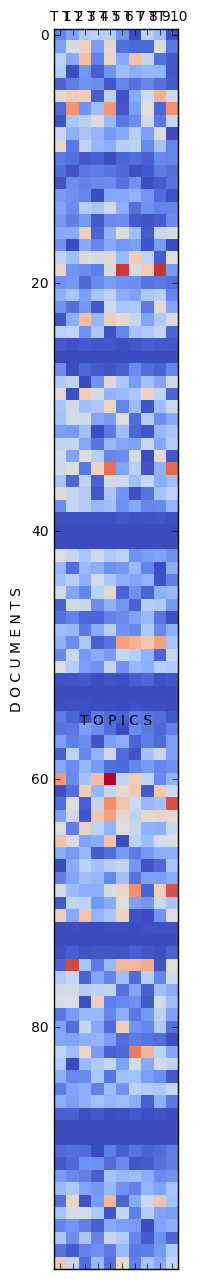

In [181]:
plt.matshow(U[100:200], cmap="coolwarm")
plt.xticks(range(num_topic), labels_generator(num_topic, "T"))
plt.xlabel("T O P I C S", labelpad = -400)
plt.ylabel("D O C U M E N T S")
plt.show()

In [160]:
#Afghan - by issue
#setting parameters
CORPUS_PATH = '/Users/Mac/Google Drive/Thesis Anna/From PrHunter/Afgan Data/txt_data'


#importing and vectorizing data
doc_names = os.listdir(CORPUS_PATH)
file_names = sorted([os.path.join(CORPUS_PATH, fn) for fn in os.listdir(CORPUS_PATH)])
dtm = np.array(vectorizer.fit_transform(file_names).toarray())
vocab = np.array(vectorizer.get_feature_names())

#deleting "afghan" and "afghanistan"
afg_ind = [(list(vocab)).index("afghanistan"), (list(vocab)).index("afghan"), (list(vocab)).index("mujahideen"), (list(vocab)).index("mujaheddin")]
dtm = np.delete(dtm, afg_ind, 1)
vocab = np.delete(vocab, afg_ind)

In [164]:
#analysis
num_topic = 5
num_top_words = 10
U,V,n,m = nmf(dtm, num_topic)
topV=np.array( indexed_matrix( V, top_i_indexes( V, num_top_words ) ) )
topV_names=np.array( names_matrix( topV, top_i_indexes( V, num_top_words ) ) )

#top words in all topics
#printing top words for each topic
pd.DataFrame(data=topV_names.T, columns=labels_generator(num_topic, "Topic"), index = range(1, num_top_words+1))

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
1,said,kabul,government,kabul,country
2,war,soviet,islamic,government,government
3,pakistan,said,kabul,regime,regime
4,people,government,regime,people,soviet
5,foreign,people,council,islamic,kabul
6,islamic,political,said,war,afghans
7,province,pakistan,country,country,peshawar
8,area,regime,soviet,vol,said
9,regime,killed,pakistan,world,people
10,jehad,jehad,enemy,iran,jehad


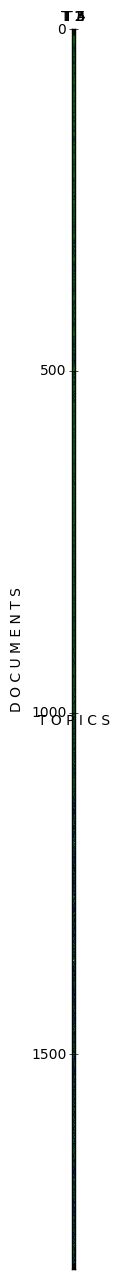

In [168]:
plt.matshow(U, cmap="coolwarm")
plt.xticks(range(num_topic), labels_generator(num_topic, "T"))
plt.xlabel("T O P I C S", labelpad = -400)
plt.ylabel("D O C U M E N T S")
plt.show()

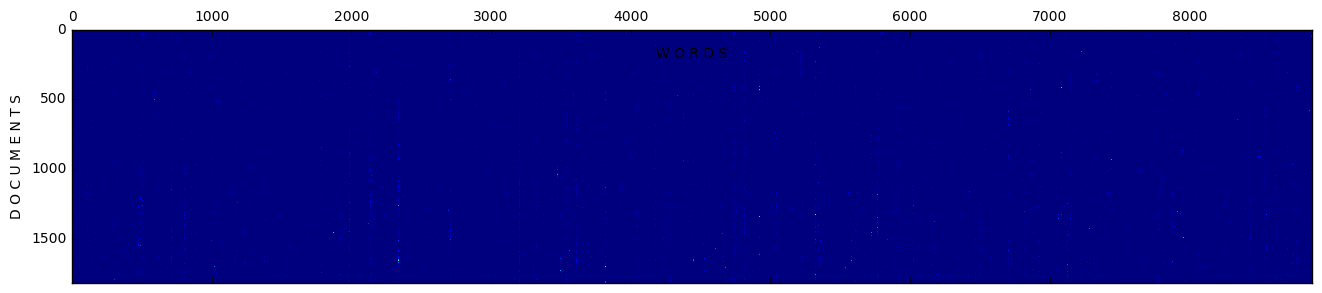

In [170]:
plt.matshow(dtm)
plt.xlabel("W O R D S", labelpad = -170)
plt.ylabel("D O C U M E N T S")
plt.show()